라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'test230417-05_LSTMJaponicaTank1'

# 한글 글꼴 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 원하는 한글 글꼴 파일 경로로 수정해주세요
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test):
    X_pred = model.predict(X_test_shape)

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('날짜')
    plt.ylabel('DO')
    plt.title('시계열')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test)
    print("MSE // MAE // R-squared ", result)
    

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

#자포니카 훈련 및 검증 데이터 시계열 변환
japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 날짜 데이터를 인덱스로 전환
japonica_training.set_index('mea_dt', inplace=True)
japonica_validation.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training = japonica_training.sort_index()
japonica_validation = japonica_validation.sort_index()

In [4]:
# 사용할 features 선택
feature_origin = ['tank_id','do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

In [5]:
# 독립 변수, 종속 변수 분리
feature_Learning = ['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy']
feature_number = len(feature_Learning)

# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_training_features_tank = japonica_training_features[japonica_training_features['tank_id']==tank]
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

japonica_training_features_X = japonica_training_features_tank[feature_Learning]
japonica_training_features_y = japonica_training_features_tank[['do_mg']]
japonica_validation_features_X = japonica_validation_features_tank[feature_Learning]
japonica_validation_features_y = japonica_validation_features_tank[['do_mg']]

In [6]:
# LSTM학습을 위해 데이터 reshape를 해야함. reshape를 위해 배열형으로 변환
japonica_training_features_X_reshape = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_validation_features_X_reshape = np.asarray(japonica_validation_features_X, dtype=np.float64)

# 데이터를 3항으로 reshape. (batch_size, timesteps, features)
# batch_size: 한 번에 모델에 입력되는 샘플의 개수
# timesteps: 입력되는 시퀀스 데이터의 길이(시간축)
# features: 입력되는 데이터의 특성 개수
# 말이 어려우니까 쉽게 쓰면 (얼마 만큼의 샘플을, 시간 당 몇 개씩, 항목이 몇 개인가)
# (-1 : 있는 만큼의 샘플을, 1 : 시간당 1개씩, 8 : 피처는 8개입니다.)
japonica_training_features_X_reshape = japonica_training_features_X_reshape.reshape((-1, 1, feature_number))
japonica_validation_features_X_reshape = japonica_validation_features_X_reshape.reshape((-1, 1, feature_number))

In [7]:
# shape확인
nCar = japonica_training_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_training_features_X_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y.shape[0] # 데이터 개수
nVar = japonica_training_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = japonica_validation_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y.shape[0] # 데이터 개수
nVar = japonica_validation_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 222751 nVar: 5
nCar: 222751 nVar: 1
nCar: 222751 nVar: 5
nCar: 222751 nVar: 1


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [8]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(1, feature_number), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.

hist = model.fit(japonica_training_features_X_reshape, japonica_training_features_y, epochs = 200, batch_size = 64, validation_data=(japonica_validation_features_X_reshape, japonica_validation_features_y), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            68608     
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 130,465
Trainable params: 130,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
3481/3481 [==============================] - 30s 7ms/step - loss: 2.7632 - mae: 1.2625 - r_squared: 0.0572 - val_loss: 2.0278 - val_mae: 1.0864 - val_r_squared: -91.5794 

모델 평가

모델 평가

In [8]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 7.19734058e-02  1.20627843e-01 -1.96263552e-01 ...  8.80134627e-02
  -3.03279281e-01 -5.44802547e-02]
 [ 8.86726528e-02  1.33918196e-01 -7.74460062e-02 ...  1.41069293e-01
   2.46885821e-01  8.72633696e-01]
 [-8.82523060e-02  1.44753128e-01  9.29621980e-02 ...  1.28417447e-01
  -9.73755866e-02  3.50261107e-02]
 [-1.13988765e-01 -4.46517207e-02 -6.48079216e-01 ...  5.69030121e-02
   1.06386602e+00  1.28606707e-01]
 [-8.79803032e-04 -4.81520444e-02  1.85084629e+01 ...  1.42852172e-01
   4.71034423e-02 -1.35818815e+00]]


c:\Users\rladn\anaconda3\envs\doRegressor\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


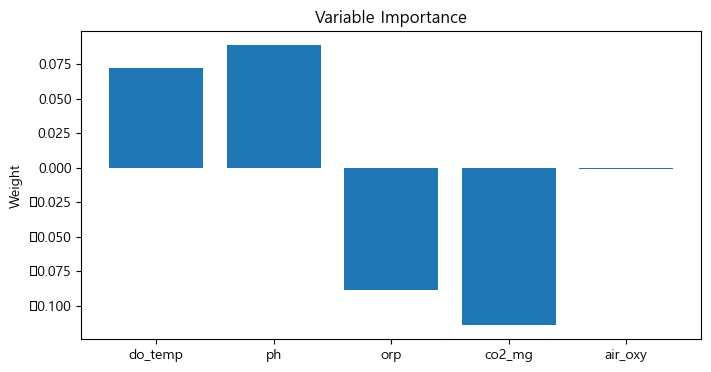

In [9]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(feature_number), weights[:, 0])
ax.set_xticks(range(feature_number))
ax.set_xticklabels(feature_Learning)
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

6961/6961 [==============================] - 14s 2ms/step


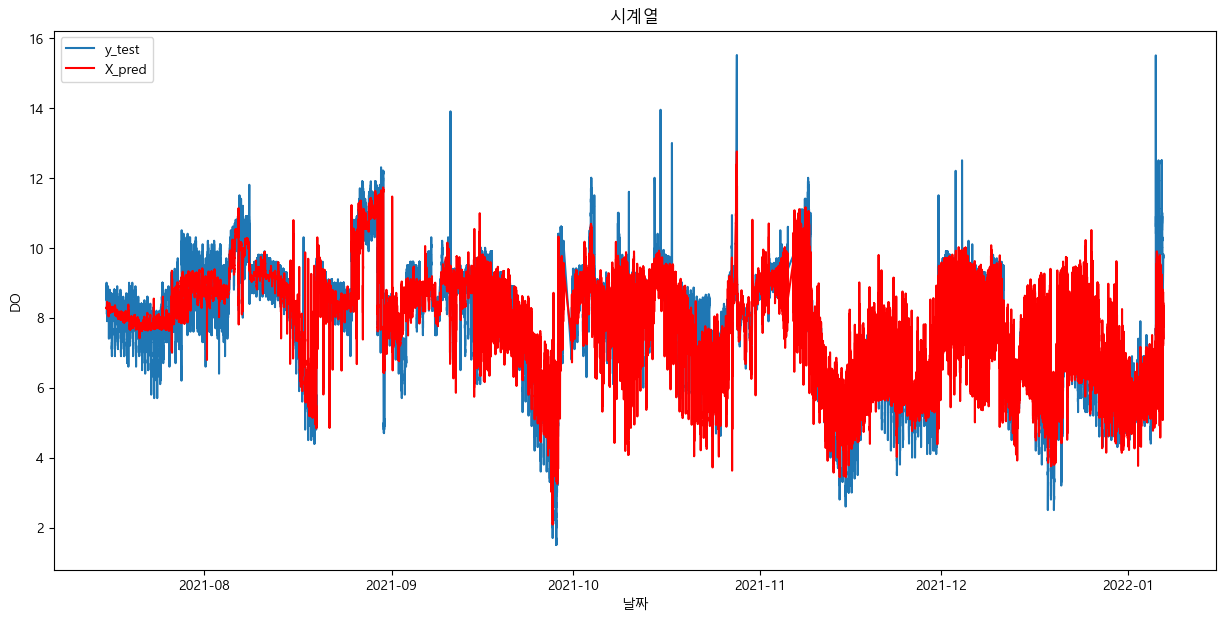

6961/6961 [==============================] - 15s 2ms/step - loss: 0.6303 - mae: 0.5235 - r_squared: -133.9545
MSE // MAE // R-squared  [0.6303078532218933, 0.5235403180122375, -133.95449829101562]


In [10]:
grapeNEva(model, japonica_validation_features_X_reshape, japonica_validation_features_y)

In [11]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-07-16 00:00:00':'2021-07-16 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 5
nCar: 1440 nVar: 1


45/45 [==============================] - 0s 2ms/step


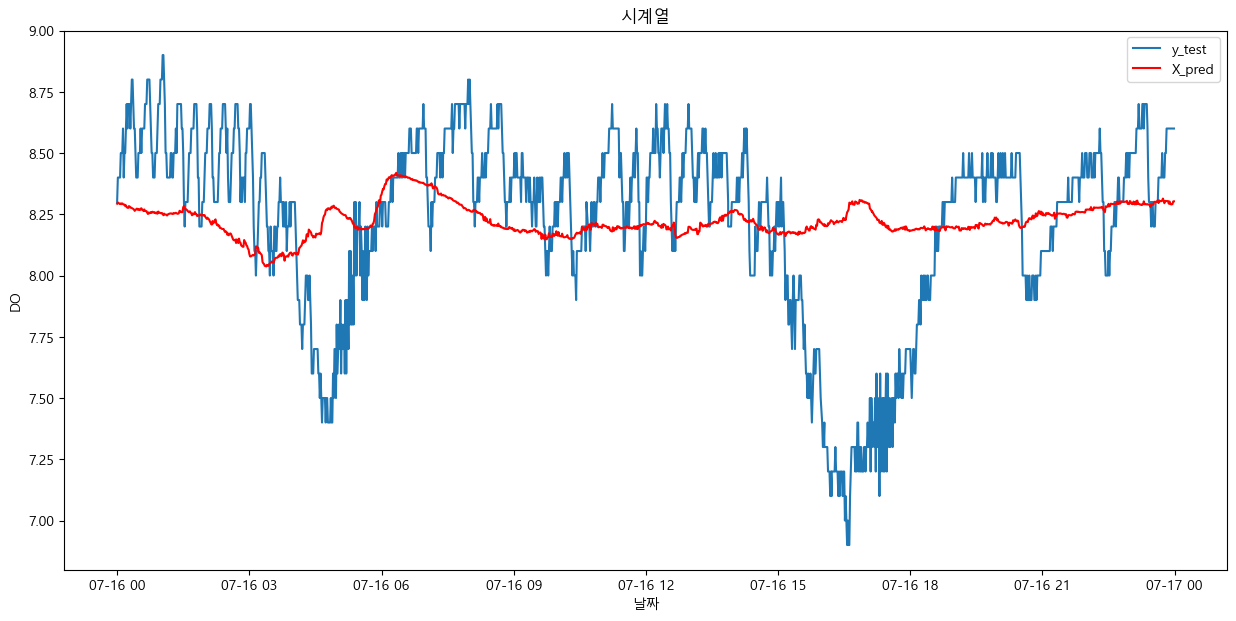

45/45 [==============================] - 0s 2ms/step - loss: 0.1454 - mae: 0.2866 - r_squared: -10.1775
MSE // MAE // R-squared  [0.14542505145072937, 0.2866366505622864, -10.177547454833984]


In [12]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)

In [13]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-08-28 00:00:00':'2021-08-28 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 5
nCar: 1440 nVar: 1


45/45 [==============================] - 0s 2ms/step


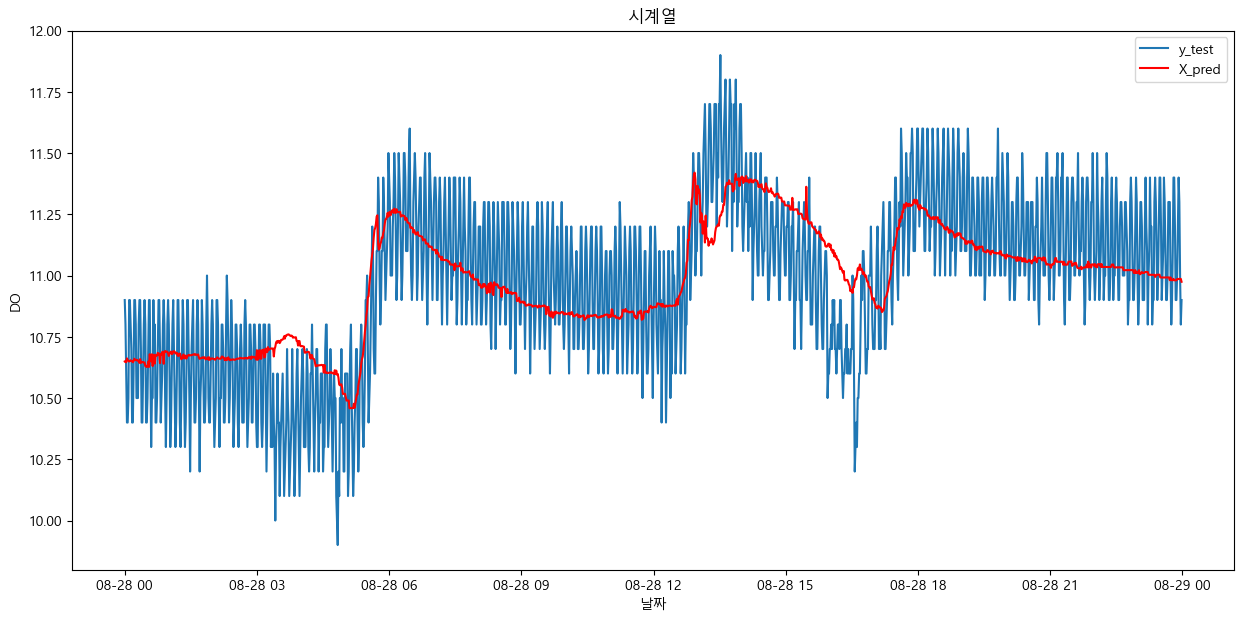

45/45 [==============================] - 0s 3ms/step - loss: 0.0595 - mae: 0.2024 - r_squared: -0.5937
MSE // MAE // R-squared  [0.059484366327524185, 0.20241416990756989, -0.5937191247940063]


In [15]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)